# PyTorch Basics Notebook
### Introduction to Tensors, Datasets, DataLoaders, CNNs, and U‑Net Building Blocks

## Import Required Libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt


## PyTorch Tensors

In [2]:
# Creating tensors
x = torch.tensor([1.0, 2.0, 3.0])
y = torch.randn(3)  # random tensor

print(x)
print(y)

# Tensor operations
print('Addition:', x + y)
print('Mean:', x.mean())


tensor([1., 2., 3.])
tensor([-0.3288,  1.4915,  0.1016])
Addition: tensor([0.6712, 3.4915, 3.1016])
Mean: tensor(2.)


## Autograd Basics

In [3]:
# Enable gradient tracking
a = torch.tensor([2.0, 3.0], requires_grad=True)
b = (a * a).sum()
b.backward()
print(a.grad)  # derivative of x^2 is 2x


tensor([4., 6.])


## Custom PyTorch Dataset

We simulate MRI-like slices using random arrays just for practice.

In [4]:
class RandomMRIDataset(Dataset):
    def __init__(self, length=100):
        self.length = length

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        image = torch.randn(1, 64, 64)      # fake MRI slice
        mask = (torch.randn(1, 64, 64) > 0).float()  # fake mask
        return image, mask

dataset = RandomMRIDataset()
img, msk = dataset[0]
img.shape, msk.shape


(torch.Size([1, 64, 64]), torch.Size([1, 64, 64]))

## DataLoader

In [5]:
loader = DataLoader(dataset, batch_size=8, shuffle=True)

for images, masks in loader:
    print(images.shape, masks.shape)
    break


torch.Size([8, 1, 64, 64]) torch.Size([8, 1, 64, 64])


## Building a Simple CNN

In [6]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32 * 16 * 16, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        return self.classifier(x)

model = SimpleCNN()
print(model)


SimpleCNN(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=8192, out_features=1, bias=True)
    (2): Sigmoid()
  )
)


## Training Loop Example

In [7]:
model = SimpleCNN()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(2):
    for images, masks in loader:
        optimizer.zero_grad()
        preds = model(images)
        loss = criterion(preds, torch.zeros_like(preds))  # dummy target
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}, Loss: {loss.item():.4f}')


Epoch 1, Loss: 0.0000
Epoch 2, Loss: 0.0000


## U‑Net Building Blocks

In [8]:
def conv_block(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.ReLU()
    )

sample = torch.randn(1, 1, 128, 128)
block = conv_block(1, 16)
output = block(sample)
output.shape


torch.Size([1, 16, 128, 128])

## Exercises


1. Modify `RandomMRIDataset` to return a resized (128×128) slice using interpolation.  
2. Add another convolution layer to `SimpleCNN` and observe how the model size changes.  
3. Implement a small encoder-decoder network (mini U-Net) using `conv_block`.  
4. Write a custom Dice Loss function in PyTorch.  
5. Train the CNN on the random dataset and plot the loss curve using matplotlib.  


In [9]:
import torch.nn.functional as F

class RandomMRIDataset(Dataset):
    def __init__(self, length=100):
        self.length = length

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        image = torch.randn(1, 64, 64)
        mask = (torch.randn(1, 64, 64) > 0).float()

        # Resize to 128×128
        image = F.interpolate(image.unsqueeze(0), size=(128, 128), mode='bilinear', align_corners=False).squeeze(0)
        mask = F.interpolate(mask.unsqueeze(0), size=(128, 128), mode='nearest').squeeze(0)

        return image, mask


In [10]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 16, 3, padding=1),  # NEW layer
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32 * 16 * 16, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.classifier(self.encoder(x))


In [11]:
sum(p.numel() for p in model.parameters())


12993

In [12]:
class MiniUNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc1 = conv_block(1, 16)
        self.pool1 = nn.MaxPool2d(2)

        self.enc2 = conv_block(16, 32)
        self.pool2 = nn.MaxPool2d(2)

        self.bottleneck = conv_block(32, 64)

        self.up2 = nn.ConvTranspose2d(64, 32, 2, stride=2)
        self.dec2 = conv_block(64, 32)

        self.up1 = nn.ConvTranspose2d(32, 16, 2, stride=2)
        self.dec1 = conv_block(32, 16)

        self.out = nn.Conv2d(16, 1, 1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool1(e1))
        b = self.bottleneck(self.pool2(e2))

        d2 = self.dec2(torch.cat([self.up2(b), e2], dim=1))
        d1 = self.dec1(torch.cat([self.up1(d2), e1], dim=1))

        return torch.sigmoid(self.out(d1))


In [13]:
class DiceLoss(nn.Module):
    def __init__(self, smooth=1.0):
        super().__init__()
        self.smooth = smooth

    def forward(self, preds, targets):
        preds = preds.view(-1)
        targets = targets.view(-1)

        intersection = (preds * targets).sum()
        dice = (2. * intersection + self.smooth) / \
               (preds.sum() + targets.sum() + self.smooth)

        return 1 - dice


In [14]:
model = SimpleCNN()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

losses = []

for epoch in range(5):
    epoch_loss = 0
    for images, masks in loader:
        optimizer.zero_grad()
        preds = model(images)
        loss = criterion(preds, torch.zeros_like(preds))
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    losses.append(epoch_loss)
    print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}")


Epoch 1, Loss: 1.1905
Epoch 2, Loss: 0.0000
Epoch 3, Loss: 0.0000
Epoch 4, Loss: 0.0000
Epoch 5, Loss: 0.0000


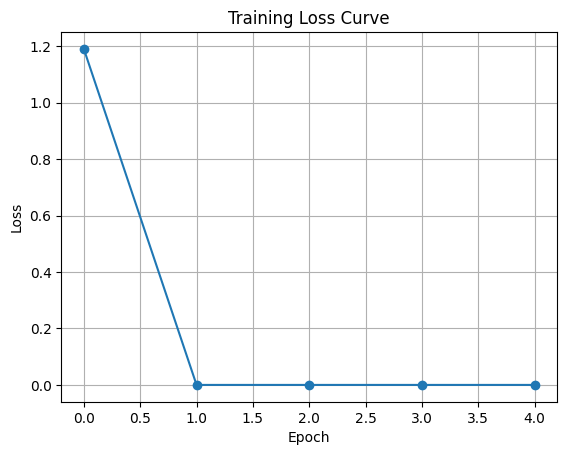

In [15]:
plt.plot(losses, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.grid()
plt.show()
